In [1]:
### I disabled my GPU since most of you will not have that
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## DavisSML Tensorflow Lab 2

Some content is taken from 
- www.tensorflow.org 
- http://rail.eecs.berkeley.edu/deeprlcourse/

To install tensorflow and keras use pip:
`pip install tensorflow`, `pip install keras`

### Keras

- high level API, typically do not interact with Tensors as in base tensorflow
- build Models from Layers
- integrated with Datasets API
- extensible : can build custom layers

In [1]:
from __future__ import print_function
import keras
from keras import layers, datasets, models
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Models and Layers

- Models contain Layers (in a graph)
- Layers contain all of the tensors, variables, operations, etc.
- Sequential graph is just a stack of layers (one feeds into the next)

In [2]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# Add another:
model.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

See the layers that are in the model here:

In [9]:
model.layers

Layers have 
- activation parameter: can be `tf.sigmoid` or 'sigmoid' for example
- kernel initializer, bias initializer: how to initialize coefficients or intercept
- kernel_regularizer, bias_regularizer: regularizers for coefficients and intercepts

In [10]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation=tf.sigmoid,kernel_initializer='orthogonal')) # random orthogonal matrix init
# Add another:
model.add(layers.Dense(64, activation='relu',kernel_regularizer = keras.regularizers.l1(0.01))) # l1 regularizer
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

Model compile:
- optimizer: ex. tf.train.AdamOptimizer, tf.train.RMSPropOptimizer, tf.train.GradientDescentOptimizer
- loss: mse, categorical_crossentropy, and binary_crossentropy
- metrics: monitoring training

Documentation: [Losses](https://keras.io/losses/), [Metrics](https://keras.io/metrics/), [Optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

In [11]:
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model fit will run the optimizer with epochs, batch_size, validation_data 

In [12]:
import numpy as np

data = np.random.random((1000, 32))
labels = np.random.random((1000, 10))

model.fit(data, labels, epochs=10, batch_size=32)

Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 15.4082 - acc: 0.0880
Epoch 2/10
1000/1000 [==============================] - 0s 96us/step - loss: 14.4723 - acc: 0.0750
Epoch 3/10
1000/1000 [==============================] - 0s 97us/step - loss: 13.6801 - acc: 0.0950
Epoch 4/10
1000/1000 [==============================] - 0s 97us/step - loss: 13.0243 - acc: 0.0800
Epoch 5/10
1000/1000 [==============================] - 0s 95us/step - loss: 12.4948 - acc: 0.1130
Epoch 6/10
1000/1000 [==============================] - 0s 97us/step - loss: 12.0927 - acc: 0.1070
Epoch 7/10
1000/1000 [==============================] - 0s 96us/step - loss: 11.8260 - acc: 0.1040
Epoch 8/10
1000/1000 [==============================] - 0s 97us/step - loss: 11.6751 - acc: 0.1150
Epoch 9/10
1000/1000 [==============================] - 0s 95us/step - loss: 11.5801 - acc: 0.1100
Epoch 10/10
1000/1000 [==============================] - 0s 100us/step - loss: 11.5148 - acc: 0.1110


### Custom layer
- build: Create the weights of the layer. Add weights with the add_weight method.
- call: Define the forward pass.
- compute_output_shape: Specify how to compute the output shape of the layer given the input shape.

In [13]:
for l in model.layers:
    print("{} : {} to {}".format(l.name,l.input_shape,l.output_shape))

dense_4 : (None, 32) to (None, 64)
dense_5 : (None, 64) to (None, 64)
dense_6 : (None, 64) to (None, 10)


In [9]:
class MyLayer(layers.Layer):

  def __init__(self, output_dim, **kwargs):
    self.output_dim = output_dim
    super(MyLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    shape = tf.TensorShape((input_shape[1], self.output_dim))
    # Create a trainable weight variable for this layer.
    self.kernel = self.add_weight(name='kernel',
                                  shape=shape,
                                  initializer='uniform',
                                  trainable=True)
    # Make sure to call the `build` method at the end
    super(MyLayer, self).build(input_shape)

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)

  def compute_output_shape(self, input_shape):
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.output_dim
    return tf.TensorShape(shape)

### Image data

We will create a model that includes
- convolutional layers: convolution of a kernel of certain size, number of channels, activation
- pooling: max pooling for example, pool size
- dropout: dropout probability

In [14]:
batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

In [15]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

11493376/11490434 [==============================] - 2s 0us/step


In [16]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [17]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

In [18]:
for l in model.layers:
    print("{} : {} to {}".format(l.name,l.input_shape,l.output_shape))

conv2d_1 : (None, 28, 28, 1) to (None, 26, 26, 32)
max_pooling2d_1 : (None, 26, 26, 32) to (None, 13, 13, 32)
conv2d_2 : (None, 13, 13, 32) to (None, 11, 11, 64)
max_pooling2d_2 : (None, 11, 11, 64) to (None, 5, 5, 64)
flatten_1 : (None, 5, 5, 64) to (None, 1600)
dense_7 : (None, 1600) to (None, 128)
dropout_1 : (None, 128) to (None, 128)
dense_8 : (None, 128) to (None, 10)


In [19]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

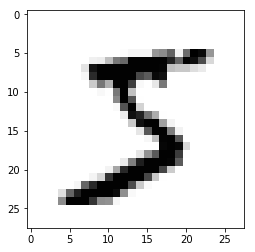

In [20]:
plt.imshow(x_train[0,...,0],cmap='Greys')

In [21]:
layer_outputs = [layer.output for layer in model.layers[:4]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [22]:
activations = activation_model.predict(x_train[[0],...]) 
# Returns a list of five Numpy arrays: one array per layer activation

c:\users\lahiru d. chamain\anaconda3\envs\tfgpumy\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


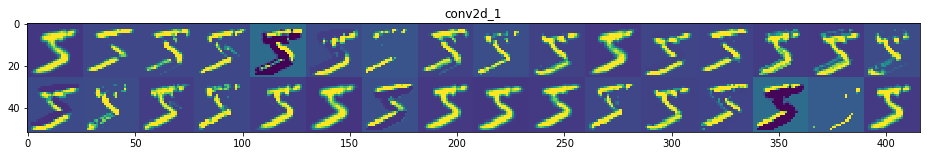

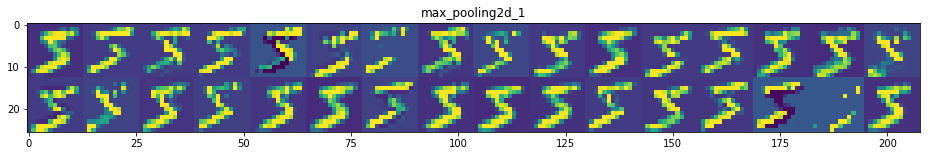

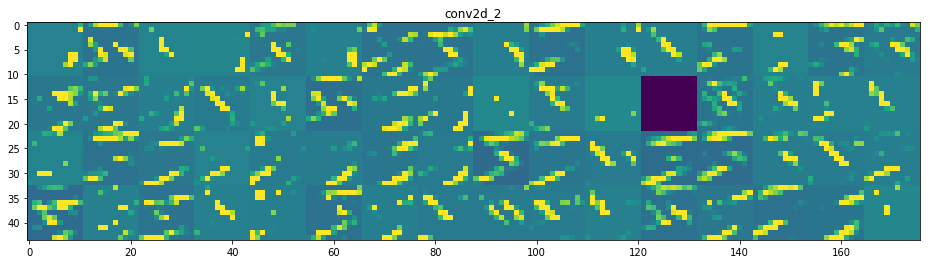

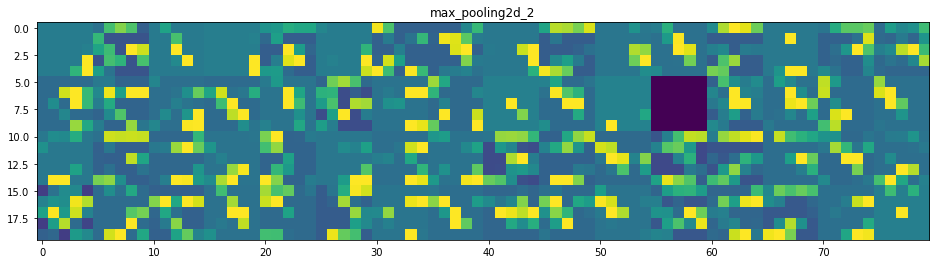

In [23]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

after this layer it's goof to flatten because there is no neighboring info

__Exercise 1__ In the above model we selected a sequence of convolutions, pooling, dropouts, and dense layers.  Run the following experiments with 4 epochs and 32 minibatch size, each time reporting the accuracy.

- Remove dropout layers.
- Remove first max pooling layer, does it take longer or shorter to train?
- Try sigmoid activation functions instead of ReLU.

In [25]:
batch_size = 32
num_classes = 10
epochs = 4

In [29]:
# Remove the dropouts and then nax pooling -1
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total para

We got a training acc of 99.35% and test acc of 99.09%. Training takes on average 16/epoch*4 epochs = 64 seconds

In [27]:
# Remove the dropouts
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


We got a training acc of 99.60% and test acc of 99.03%. Training takes on average 35/epoch*4 epochs = 140 seconds.
With the maxpooling-1 removed, we get lower training and test accuracy and takes longer time, x2 times compared to the case with maxpooing-1. This is beacuse with maxpoolong it halves the image shape after that layer, making the rest of the propagation faster.

In [30]:
#Sigmoid instead of relu

model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='sigmoid'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='sigmoid'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               204928    
__________

We got a training acc of 97.25% and test acc of 97.86%. Training takes on average 16/epoch*4 epochs = 64 seconds